<a href="https://colab.research.google.com/github/Mobinafathi78/Mobina-Fathi-CV/blob/main/Lung_Image_Segmentation_Dataset_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("beosup/lung-segment")

print("Path to dataset files:", path)

100%|██████████| 4.10G/4.10G [00:51<00:00, 85.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1


In [2]:
import os

dataset_path = kagglehub.dataset_download("beosup/lung-segment")
print("✅ Dataset path:", dataset_path)

# بررسی ساختار
for root, dirs, files in os.walk(dataset_path):
    print("📁 Directory:", root)
    print("📄 Files:", files[:5])
    print("-" * 40)


✅ Dataset path: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1
📁 Directory: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1
📄 Files: ['test.csv', 'train.csv', 'README.md']
----------------------------------------
📁 Directory: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/images
📄 Files: ['644.png', '674.png', '54.png', '598.png', '263.png']
----------------------------------------
📁 Directory: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/masks
📄 Files: ['335-mask.png', '54-mask.png', '227-mask.png', '130-mask.png', '625-mask.png']
----------------------------------------


In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LungSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.file_list = file_list  # لیست نام فایل‌ها بدون پسوند

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_id = self.file_list[idx]
        image_path = os.path.join(self.images_dir, f"{img_id}.png")
        mask_path = os.path.join(self.masks_dir, f"{img_id}-mask.png")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask


In [5]:
import pandas as pd

csv_path = "/root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/train.csv"
train_df = pd.read_csv(csv_path)
print("ستون‌های فایل train.csv:")
print(train_df.columns)
train_df.head()


ستون‌های فایل train.csv:
Index(['Unnamed: 0', 'images', 'masks'], dtype='object')


,Unnamed: 0,images,masks
0,0,images/0.png,masks/0-mask.png
1,1,images/1.png,masks/1-mask.png
2,2,images/2.png,masks/2-mask.png
3,3,images/3.png,masks/3-mask.png
4,4,images/5.png,masks/5-mask.png


In [6]:
# مسیر اصلی دیتاست
BASE_PATH = "/root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1"
train_df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))

# گرفتن مسیر کامل فایل‌ها
image_paths = [os.path.join(BASE_PATH, row['images']) for _, row in train_df.iterrows()]
mask_paths = [os.path.join(BASE_PATH, row['masks']) for _, row in train_df.iterrows()]


In [7]:
class LungSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask


In [8]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = LungSegmentationDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


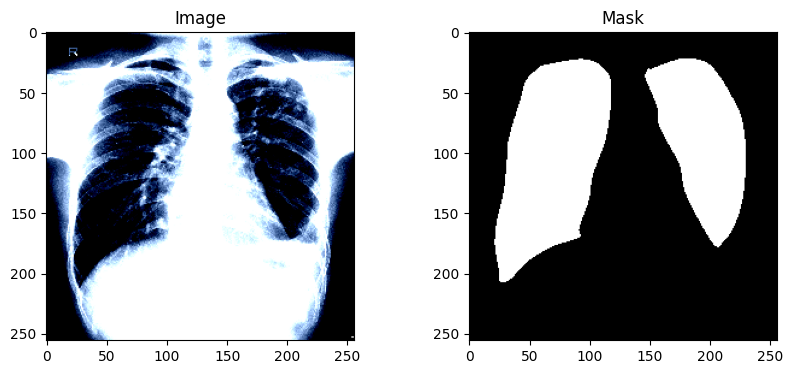

In [9]:
import matplotlib.pyplot as plt

img, mask = train_dataset[0]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Mask")
plt.show()


In [10]:
!pip install segmentation-models-pytorch --quiet


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import segmentation_models_pytorch as smp
import torch

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define U-Net model with ResNet34 encoder and 1 output class (binary mask)
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


In [12]:
import torch.nn as nn
import torch.optim as optim

# Combine Dice Loss + Binary Cross Entropy for stability
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def total_loss(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [13]:
def dice_coef(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred * y_true).sum()
    return (2. * intersection) / (y_pred.sum() + y_true.sum() + eps)

def iou_score(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    return intersection / (union + eps)


In [14]:
from tqdm import tqdm

def train(model, dataloader, optimizer, loss_fn, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_dice = 0
        epoch_iou = 0

        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_dice += dice_coef(preds, masks).item()
            epoch_iou += iou_score(preds, masks).item()

        print(f"\n📍 Epoch {epoch+1}")
        print(f"   - Loss:  {epoch_loss / len(dataloader):.4f}")
        print(f"   - Dice:  {epoch_dice / len(dataloader):.4f}")
        print(f"   - IoU:   {epoch_iou / len(dataloader):.4f}")


In [15]:
train(model, train_loader, optimizer, total_loss, num_epochs=5)


 20%|██        | 18/88 [03:44<14:33, 12.48s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_img, sample_mask = train_dataset[0]
    pred_mask = model(sample_img.unsqueeze(0).to(device))
    pred_mask = torch.sigmoid(pred_mask).cpu().squeeze().numpy()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_img.permute(1, 2, 0))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask > 0.5, cmap='gray')
plt.title("Predicted Mask")
plt.show()


In [16]:
import pandas as pd

csv_path = "/root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/train.csv"
train_df = pd.read_csv(csv_path)

num_samples = len(train_df)
print(f"📊 Total number of samples (image-mask pairs): {num_samples}")


📊 Total number of samples (image-mask pairs): 704


In [19]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

def train(model, dataloader, optimizer, loss_fn, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        total_f1 = 0
        total_dice = 0
        total_iou = 0
        total = 0

        print(f"\n🚀 Epoch {epoch + 1}/{num_epochs} started...\n")

        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True):
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)

            # Compute loss
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            # Convert predictions to binary
            preds_bin = (torch.sigmoid(preds) > 0.5).float()

            # Flatten for metric calculation
            y_true = masks.detach().cpu().numpy().reshape(-1)
            y_pred = preds_bin.detach().cpu().numpy().reshape(-1)

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, zero_division=1)

            # Dice and IoU (already in tensor)
            dice = dice_coef(preds, masks).item()
            iou = iou_score(preds, masks).item()

            batch_size = images.size(0)
            total_accuracy += acc * batch_size
            total_f1 += f1 * batch_size
            total_dice += dice * batch_size
            total_iou += iou * batch_size
            total += batch_size

        print(f"📍 Epoch {epoch+1} Summary:")
        print(f"   🔻 Loss     : {total_loss / total:.4f}")
        print(f"   ✅ Accuracy : {total_accuracy / total:.4f}")
        print(f"   🧠 F1 Score : {total_f1 / total:.4f}")
        print(f"   🎯 Dice     : {total_dice / total:.4f}")
        print(f"   🔁 IoU      : {total_iou / total:.4f}")


In [1]:
# 1. Install Required Libraries
!pip install -q segmentation-models-pytorch albumentations

# 2. Imports
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import segmentation_models_pytorch as smp

# 3. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Dataset Class
class LungSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask

# 5. Load Paths
base_path = "/root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1"
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
image_paths = [os.path.join(base_path, row['images']) for _, row in train_df.iterrows()]
mask_paths = [os.path.join(base_path, row['masks']) for _, row in train_df.iterrows()]

# 6. Transforms
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

# 7. Dataset and Dataloader
train_dataset = LungSegmentationDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# 8. Model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# 9. Loss + Optimizer
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def total_loss(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 10. Dice & IoU
def dice_coef(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred * y_true).sum()
    return (2. * intersection) / (y_pred.sum() + y_true.sum() + eps)

def iou_score(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    return intersection / (union + eps)

# 11. Training Function
def train(model, dataloader, optimizer, loss_fn, num_epochs=200):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        total_f1 = 0
        total_dice = 0
        total_iou = 0
        total = 0

        print(f"\n🚀 Epoch {epoch + 1}/{num_epochs} started...\n")

        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True):
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            preds_sigmoid = torch.sigmoid(preds)
            preds_bin = (preds_sigmoid > 0.5).float()

            y_true = (masks.detach().cpu().numpy().reshape(-1) > 0.5).astype('uint8')
            y_pred = preds_bin.detach().cpu().numpy().reshape(-1).astype('uint8')

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, zero_division=1)
            dice = dice_coef(preds, masks).item()
            iou = iou_score(preds, masks).item()

            batch_size = images.size(0)
            total_accuracy += acc * batch_size
            total_f1 += f1 * batch_size
            total_dice += dice * batch_size
            total_iou += iou * batch_size
            total += batch_size

        print(f"📍 Epoch {epoch+1} Summary:")
        print(f"   🔻 Loss     : {total_loss / total:.4f}")
        print(f"   ✅ Accuracy : {total_accuracy / total:.4f}")
        print(f"   🧠 F1 Score : {total_f1 / total:.4f}")
        print(f"   🎯 Dice     : {total_dice / total:.4f}")
        print(f"   🔁 IoU      : {total_iou / total:.4f}")

# 12. Start Training
train(model, train_loader, optimizer, total_loss, num_epochs=200)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/train.csv'

In [2]:
# 1. نصب کتابخانه‌ها
!pip install -q segmentation-models-pytorch albumentations kagglehub

# 2. ایمپورت‌ها
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import segmentation_models_pytorch as smp
import kagglehub

# 3. تنظیم دیوایس
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Device:", device)

# 4. دانلود دیتاست و تنظیم مسیرها
dataset_path = kagglehub.dataset_download("beosup/lung-segment")
print("✅ Dataset path:", dataset_path)

train_csv = os.path.join(dataset_path, "train.csv")
train_df = pd.read_csv(train_csv)

image_paths = [os.path.join(dataset_path, row['images']) for _, row in train_df.iterrows()]
mask_paths = [os.path.join(dataset_path, row['masks']) for _, row in train_df.iterrows()]

# 5. کلاس دیتاست
class LungSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask

# 6. ترنسفورم‌ها و DataLoader
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = LungSegmentationDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# 7. تعریف مدل U-Net
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# 8. Loss Function و Optimizer
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def total_loss(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 9. متریک‌ها: Dice و IoU
def dice_coef(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred * y_true).sum()
    return (2. * intersection) / (y_pred.sum() + y_true.sum() + eps)

def iou_score(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    return intersection / (union + eps)

# 10. حلقه آموزش
def train(model, dataloader, optimizer, loss_fn, num_epochs=200):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        total_f1 = 0
        total_dice = 0
        total_iou = 0
        total = 0

        print(f"\n🚀 Epoch {epoch + 1}/{num_epochs} started...\n")

        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True):
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            preds_sigmoid = torch.sigmoid(preds)
            preds_bin = (preds_sigmoid > 0.5).float()

            y_true = (masks.detach().cpu().numpy().reshape(-1) > 0.5).astype('uint8')
            y_pred = preds_bin.detach().cpu().numpy().reshape(-1).astype('uint8')

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, zero_division=1)
            dice = dice_coef(preds, masks).item()
            iou = iou_score(preds, masks).item()

            batch_size = images.size(0)
            total_accuracy += acc * batch_size
            total_f1 += f1 * batch_size
            total_dice += dice * batch_size
            total_iou += iou * batch_size
            total += batch_size

        print(f"📍 Epoch {epoch+1} Summary:")
        print(f"   🔻 Loss     : {total_loss / total:.4f}")
        print(f"   ✅ Accuracy : {total_accuracy / total:.4f}")
        print(f"   🧠 F1 Score : {total_f1 / total:.4f}")
        print(f"   🎯 Dice     : {total_dice / total:.4f}")
        print(f"   🔁 IoU      : {total_iou / total:.4f}")

# 11. اجرای آموزش
train(model, train_loader, optimizer, total_loss, num_epochs=200)


🚀 Device: cuda


100%|██████████| 4.10G/4.10G [03:13<00:00, 22.8MB/s]

Extracting files...


✅ Dataset path: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 325MB/s]



🚀 Epoch 1/200 started...



Epoch 1: 100%|██████████| 88/88 [02:36<00:00,  1.77s/it]


📍 Epoch 1 Summary:
   🔻 Loss     : -129.2865
   ✅ Accuracy : 0.8331
   🧠 F1 Score : 0.7418
   🎯 Dice     : 1.8355
   🔁 IoU      : 38.7753

🚀 Epoch 2/200 started...



Epoch 2: 100%|██████████| 88/88 [02:31<00:00,  1.72s/it]


📍 Epoch 2 Summary:
   🔻 Loss     : -305.0354
   ✅ Accuracy : 0.9582
   🧠 F1 Score : 0.9215
   🎯 Dice     : 1.9522
   🔁 IoU      : 55.1062

🚀 Epoch 3/200 started...



Epoch 3:  22%|██▏       | 19/88 [00:34<02:05,  1.82s/it]


KeyboardInterrupt: 

In [3]:
# 1. نصب کتابخانه‌ها
!pip install -q segmentation-models-pytorch albumentations kagglehub

# 2. ایمپورت‌ها
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import segmentation_models_pytorch as smp
import kagglehub

# 3. تنظیم GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Device:", device)

# 4. دانلود دیتاست
dataset_path = kagglehub.dataset_download("beosup/lung-segment")
print("✅ Dataset path:", dataset_path)

# 5. خواندن فایل CSV و مسیرها
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
image_paths = [os.path.join(dataset_path, row['images']) for _, row in train_df.iterrows()]
mask_paths = [os.path.join(dataset_path, row['masks']) for _, row in train_df.iterrows()]

# 6. تعریف Dataset
class LungSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('float32')  # Make sure mask is binary

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask

# 7. تعریف ترنسفورم‌ها و dataloader
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = LungSegmentationDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# 8. تعریف مدل U-Net
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# 9. تعریف Loss و Optimizer
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def total_loss(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 10. متریک‌های دقیق و اصلاح‌شده
def dice_coef(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    y_true = y_true.float()
    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_score(y_pred, y_true, threshold=0.5, eps=1e-7):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    y_true = y_true.float()
    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    total = (y_pred + y_true).sum(dim=(1, 2, 3))
    union = total - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

# 11. تابع آموزش
def train(model, dataloader, optimizer, loss_fn, num_epochs=200):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        total_f1 = 0
        total_dice = 0
        total_iou = 0
        total = 0

        print(f"\n🚀 Epoch {epoch + 1}/{num_epochs} started...\n")

        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True):
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            preds_bin = (torch.sigmoid(preds) > 0.5).float()
            y_true = (masks.detach().cpu().numpy().reshape(-1) > 0.5).astype('uint8')
            y_pred = preds_bin.detach().cpu().numpy().reshape(-1).astype('uint8')

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, zero_division=1)
            dice = dice_coef(preds, masks)
            iou = iou_score(preds, masks)

            batch_size = images.size(0)
            total_accuracy += acc * batch_size
            total_f1 += f1 * batch_size
            total_dice += dice * batch_size
            total_iou += iou * batch_size
            total += batch_size

        print(f"📍 Epoch {epoch+1} Summary:")
        print(f"   🔻 Loss     : {total_loss / total:.4f}")
        print(f"   ✅ Accuracy : {total_accuracy / total:.4f}")
        print(f"   🧠 F1 Score : {total_f1 / total:.4f}")
        print(f"   🎯 Dice     : {total_dice / total:.4f}")
        print(f"   🔁 IoU      : {total_iou / total:.4f}")

# 12. اجرای آموزش با 200 اپوک
train(model, train_loader, optimizer, total_loss, num_epochs=200)


🚀 Device: cuda
✅ Dataset path: /kaggle/input/lung-segment

🚀 Epoch 1/200 started...



Epoch 1: 100%|██████████| 88/88 [03:02<00:00,  2.08s/it]


📍 Epoch 1 Summary:
   🔻 Loss     : 0.6888
   ✅ Accuracy : 0.9160
   🧠 F1 Score : 0.8614
   🎯 Dice     : 0.8586
   🔁 IoU      : 0.7748

🚀 Epoch 2/200 started...



Epoch 2:  84%|████████▍ | 74/88 [02:24<00:27,  1.95s/it]


KeyboardInterrupt: 

In [4]:
from sklearn.model_selection import train_test_split

# خواندن CSV
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

# مسیرهای کامل تصاویر و ماسک‌ها
image_paths = [os.path.join(dataset_path, row['images']) for _, row in train_df.iterrows()]
mask_paths = [os.path.join(dataset_path, row['masks']) for _, row in train_df.iterrows()]

# تقسیم به train و val
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths,
    mask_paths,
    test_size=0.2,
    random_state=42
)

print(f"📊 Training samples  : {len(train_imgs)}")
print(f"📊 Validation samples: {len(val_imgs)}")


📊 Training samples  : 563
📊 Validation samples: 141


In [5]:
# کلاس دیتاست بدون تغییر
# فقط دوباره تعریفش می‌کنیم برای هر بخش

train_dataset = LungSegmentationDataset(train_imgs, train_masks, transform=transform)
val_dataset   = LungSegmentationDataset(val_imgs, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [6]:
import copy

def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    total_accuracy = 0
    total_f1 = 0
    total_dice = 0
    total_iou = 0
    total = 0

    for images, masks in tqdm(loader, desc="🔁 Training", leave=False):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        preds_bin = (torch.sigmoid(preds) > 0.5).float()
        y_true = (masks.detach().cpu().numpy().reshape(-1) > 0.5).astype('uint8')
        y_pred = preds_bin.detach().cpu().numpy().reshape(-1).astype('uint8')

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=1)
        dice = dice_coef(preds, masks)
        iou = iou_score(preds, masks)

        total_accuracy += acc * images.size(0)
        total_f1 += f1 * images.size(0)
        total_dice += dice * images.size(0)
        total_iou += iou * images.size(0)
        total += images.size(0)

    return {
        'loss': total_loss / total,
        'accuracy': total_accuracy / total,
        'f1': total_f1 / total,
        'dice': total_dice / total,
        'iou': total_iou / total,
    }

def validate_one_epoch(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_f1 = 0
    total_dice = 0
    total_iou = 0
    total = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="🧪 Validation", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)
            total_loss += loss.item() * images.size(0)

            preds_bin = (torch.sigmoid(preds) > 0.5).float()
            y_true = (masks.detach().cpu().numpy().reshape(-1) > 0.5).astype('uint8')
            y_pred = preds_bin.detach().cpu().numpy().reshape(-1).astype('uint8')

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, zero_division=1)
            dice = dice_coef(preds, masks)
            iou = iou_score(preds, masks)

            total_accuracy += acc * images.size(0)
            total_f1 += f1 * images.size(0)
            total_dice += dice * images.size(0)
            total_iou += iou * images.size(0)
            total += images.size(0)

    return {
        'loss': total_loss / total,
        'accuracy': total_accuracy / total,
        'f1': total_f1 / total,
        'dice': total_dice / total,
        'iou': total_iou / total,
    }


In [7]:
import matplotlib.pyplot as plt

def train_full(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=50, save_path='best_model.pth'):
    best_dice = 0
    history = {
        'train': {'loss': [], 'accuracy': [], 'f1': [], 'dice': [], 'iou': []},
        'val':   {'loss': [], 'accuracy': [], 'f1': [], 'dice': [], 'iou': []}
    }

    for epoch in range(1, num_epochs + 1):
        print(f"\n📦 Epoch {epoch}/{num_epochs}")

        train_metrics = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_metrics   = validate_one_epoch(model, val_loader, loss_fn)

        # ذخیره متریک‌ها در history
        for key in train_metrics:
            history['train'][key].append(train_metrics[key])
            history['val'][key].append(val_metrics[key])

        # چاپ نتایج
        print(f"   🔧 Train    | Loss: {train_metrics['loss']:.4f} | Dice: {train_metrics['dice']:.4f} | F1: {train_metrics['f1']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
        print(f"   🧪 Val      | Loss: {val_metrics['loss']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f} | Acc: {val_metrics['accuracy']:.4f}")

        # ذخیره بهترین مدل بر اساس dice در val
        if val_metrics['dice'] > best_dice:
            best_dice = val_metrics['dice']
            torch.save(model.state_dict(), save_path)
            print("✅ Best model saved!")

    return history


In [ ]:
# آموزش با 200 اپوک
history = train_full(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=total_loss,
    num_epochs=200,
    save_path='best_model.pth'
)



📦 Epoch 1/200


   🔧 Train    | Loss: 0.2878 | Dice: 0.9571 | F1: 0.9578 | Acc: 0.9786
   🧪 Val      | Loss: 0.2589 | Dice: 0.9564 | F1: 0.9571 | Acc: 0.9780
✅ Best model saved!

📦 Epoch 2/200


   🔧 Train    | Loss: 0.2311 | Dice: 0.9604 | F1: 0.9609 | Acc: 0.9803
   🧪 Val      | Loss: 0.2020 | Dice: 0.9644 | F1: 0.9651 | Acc: 0.9823
✅ Best model saved!

📦 Epoch 3/200


   🔧 Train    | Loss: 0.1941 | Dice: 0.9615 | F1: 0.9620 | Acc: 0.9808
   🧪 Val      | Loss: 0.1759 | Dice: 0.9632 | F1: 0.9644 | Acc: 0.9821

📦 Epoch 4/200


   🔧 Train    | Loss: 0.1713 | Dice: 0.9616 | F1: 0.9621 | Acc: 0.9809
   🧪 Val      | Loss: 0.1598 | Dice: 0.9622 | F1: 0.9636 | Acc: 0.9817

📦 Epoch 5/200


   🔧 Train    | Loss: 0.1492 | Dice: 0.9643 | F1: 0.9647 | Acc: 0.9822
   🧪 Val      | Loss: 0.1437 | Dice: 0.9634 | F1: 0.9646 | Acc: 0.9821

📦 Epoch 6/200


   🔧 Train    | Loss: 0.1357 | Dice: 0.9650 | F1: 0.9655 | Acc: 0.9826
   🧪 Val      | Loss: 0.1332 | Dice: 0.9628 | F1: 0.9640 | Acc: 0.9817

📦 Epoch 7/200


   🔧 Train    | Loss: 0.1253 | Dice: 0.9663 | F1: 0.9665 | Acc: 0.9831
   🧪 Val      | Loss: 0.1364 | Dice: 0.9594 | F1: 0.9603 | Acc: 0.9797

📦 Epoch 8/200


   🔧 Train    | Loss: 0.1200 | Dice: 0.9654 | F1: 0.9659 | Acc: 0.9828
   🧪 Val      | Loss: 0.1162 | Dice: 0.9650 | F1: 0.9660 | Acc: 0.9830
✅ Best model saved!

📦 Epoch 9/200


   🔧 Train    | Loss: 0.1112 | Dice: 0.9673 | F1: 0.9676 | Acc: 0.9837
   🧪 Val      | Loss: 0.1112 | Dice: 0.9659 | F1: 0.9666 | Acc: 0.9832
✅ Best model saved!

📦 Epoch 10/200


   🔧 Train    | Loss: 0.1080 | Dice: 0.9667 | F1: 0.9672 | Acc: 0.9835
   🧪 Val      | Loss: 0.1104 | Dice: 0.9639 | F1: 0.9651 | Acc: 0.9823

📦 Epoch 11/200


   🔧 Train    | Loss: 0.1028 | Dice: 0.9676 | F1: 0.9680 | Acc: 0.9838
   🧪 Val      | Loss: 0.1060 | Dice: 0.9655 | F1: 0.9663 | Acc: 0.9830

📦 Epoch 12/200


   🔧 Train    | Loss: 0.0950 | Dice: 0.9695 | F1: 0.9701 | Acc: 0.9849
   🧪 Val      | Loss: 0.1110 | Dice: 0.9614 | F1: 0.9621 | Acc: 0.9809

📦 Epoch 13/200


   🔧 Train    | Loss: 0.0890 | Dice: 0.9711 | F1: 0.9716 | Acc: 0.9857
   🧪 Val      | Loss: 0.1018 | Dice: 0.9653 | F1: 0.9662 | Acc: 0.9829

📦 Epoch 14/200


   🔧 Train    | Loss: 0.0847 | Dice: 0.9723 | F1: 0.9727 | Acc: 0.9862
   🧪 Val      | Loss: 0.1020 | Dice: 0.9651 | F1: 0.9658 | Acc: 0.9827

📦 Epoch 15/200


   🔧 Train    | Loss: 0.0843 | Dice: 0.9718 | F1: 0.9720 | Acc: 0.9859
   🧪 Val      | Loss: 0.0974 | Dice: 0.9657 | F1: 0.9666 | Acc: 0.9832

📦 Epoch 16/200


   🔧 Train    | Loss: 0.0805 | Dice: 0.9725 | F1: 0.9730 | Acc: 0.9863
   🧪 Val      | Loss: 0.0951 | Dice: 0.9669 | F1: 0.9674 | Acc: 0.9836
✅ Best model saved!

📦 Epoch 17/200


   🔧 Train    | Loss: 0.0769 | Dice: 0.9736 | F1: 0.9739 | Acc: 0.9868
   🧪 Val      | Loss: 0.0983 | Dice: 0.9654 | F1: 0.9662 | Acc: 0.9830

📦 Epoch 18/200


   🔧 Train    | Loss: 0.0749 | Dice: 0.9740 | F1: 0.9743 | Acc: 0.9870
   🧪 Val      | Loss: 0.1031 | Dice: 0.9622 | F1: 0.9633 | Acc: 0.9816

📦 Epoch 19/200


   🔧 Train    | Loss: 0.0773 | Dice: 0.9728 | F1: 0.9732 | Acc: 0.9865
   🧪 Val      | Loss: 0.0993 | Dice: 0.9648 | F1: 0.9659 | Acc: 0.9827

📦 Epoch 20/200


   🔧 Train    | Loss: 0.0710 | Dice: 0.9750 | F1: 0.9752 | Acc: 0.9875
   🧪 Val      | Loss: 0.1015 | Dice: 0.9634 | F1: 0.9646 | Acc: 0.9823

📦 Epoch 21/200


   🔧 Train    | Loss: 0.0697 | Dice: 0.9752 | F1: 0.9755 | Acc: 0.9876
   🧪 Val      | Loss: 0.0995 | Dice: 0.9640 | F1: 0.9645 | Acc: 0.9821

📦 Epoch 22/200


   🔧 Train    | Loss: 0.0692 | Dice: 0.9752 | F1: 0.9755 | Acc: 0.9876
   🧪 Val      | Loss: 0.1033 | Dice: 0.9625 | F1: 0.9633 | Acc: 0.9813

📦 Epoch 23/200


   🔧 Train    | Loss: 0.0656 | Dice: 0.9762 | F1: 0.9765 | Acc: 0.9881
   🧪 Val      | Loss: 0.0977 | Dice: 0.9639 | F1: 0.9649 | Acc: 0.9824

📦 Epoch 24/200


   🔧 Train    | Loss: 0.0633 | Dice: 0.9771 | F1: 0.9774 | Acc: 0.9886
   🧪 Val      | Loss: 0.0970 | Dice: 0.9644 | F1: 0.9654 | Acc: 0.9825

📦 Epoch 25/200


   🔧 Train    | Loss: 0.0614 | Dice: 0.9776 | F1: 0.9779 | Acc: 0.9888
   🧪 Val      | Loss: 0.0992 | Dice: 0.9637 | F1: 0.9646 | Acc: 0.9820

📦 Epoch 26/200


   🔧 Train    | Loss: 0.0607 | Dice: 0.9776 | F1: 0.9779 | Acc: 0.9888
   🧪 Val      | Loss: 0.0953 | Dice: 0.9660 | F1: 0.9667 | Acc: 0.9831

📦 Epoch 27/200


   🔧 Train    | Loss: 0.0587 | Dice: 0.9784 | F1: 0.9787 | Acc: 0.9892
   🧪 Val      | Loss: 0.0942 | Dice: 0.9663 | F1: 0.9669 | Acc: 0.9834

📦 Epoch 28/200


   🔧 Train    | Loss: 0.0593 | Dice: 0.9782 | F1: 0.9783 | Acc: 0.9891
   🧪 Val      | Loss: 0.0935 | Dice: 0.9659 | F1: 0.9669 | Acc: 0.9833

📦 Epoch 29/200


   🔧 Train    | Loss: 0.0549 | Dice: 0.9796 | F1: 0.9798 | Acc: 0.9898
   🧪 Val      | Loss: 0.0938 | Dice: 0.9662 | F1: 0.9671 | Acc: 0.9834

📦 Epoch 30/200


   🔧 Train    | Loss: 0.0537 | Dice: 0.9800 | F1: 0.9802 | Acc: 0.9900
   🧪 Val      | Loss: 0.0958 | Dice: 0.9652 | F1: 0.9662 | Acc: 0.9829

📦 Epoch 31/200


   🔧 Train    | Loss: 0.0525 | Dice: 0.9803 | F1: 0.9806 | Acc: 0.9902
   🧪 Val      | Loss: 0.0956 | Dice: 0.9659 | F1: 0.9668 | Acc: 0.9832

📦 Epoch 32/200


   🔧 Train    | Loss: 0.0522 | Dice: 0.9807 | F1: 0.9808 | Acc: 0.9903
   🧪 Val      | Loss: 0.0996 | Dice: 0.9645 | F1: 0.9654 | Acc: 0.9824

📦 Epoch 33/200


   🔧 Train    | Loss: 0.0509 | Dice: 0.9807 | F1: 0.9810 | Acc: 0.9904
   🧪 Val      | Loss: 0.0968 | Dice: 0.9659 | F1: 0.9665 | Acc: 0.9832

📦 Epoch 34/200


   🔧 Train    | Loss: 0.0488 | Dice: 0.9815 | F1: 0.9818 | Acc: 0.9908
   🧪 Val      | Loss: 0.0990 | Dice: 0.9648 | F1: 0.9656 | Acc: 0.9826

📦 Epoch 35/200


   🔧 Train    | Loss: 0.0482 | Dice: 0.9818 | F1: 0.9820 | Acc: 0.9909
   🧪 Val      | Loss: 0.0992 | Dice: 0.9652 | F1: 0.9660 | Acc: 0.9829

📦 Epoch 36/200


   🔧 Train    | Loss: 0.0469 | Dice: 0.9823 | F1: 0.9825 | Acc: 0.9912
   🧪 Val      | Loss: 0.1015 | Dice: 0.9640 | F1: 0.9648 | Acc: 0.9822

📦 Epoch 37/200


   🔧 Train    | Loss: 0.0513 | Dice: 0.9804 | F1: 0.9806 | Acc: 0.9903
   🧪 Val      | Loss: 0.1019 | Dice: 0.9637 | F1: 0.9646 | Acc: 0.9821

📦 Epoch 38/200


   🔧 Train    | Loss: 0.0482 | Dice: 0.9815 | F1: 0.9817 | Acc: 0.9908
   🧪 Val      | Loss: 0.0991 | Dice: 0.9653 | F1: 0.9660 | Acc: 0.9828

📦 Epoch 39/200


   🔧 Train    | Loss: 0.0469 | Dice: 0.9820 | F1: 0.9822 | Acc: 0.9910
   🧪 Val      | Loss: 0.0969 | Dice: 0.9659 | F1: 0.9667 | Acc: 0.9831

📦 Epoch 40/200


   🔧 Train    | Loss: 0.0447 | Dice: 0.9829 | F1: 0.9831 | Acc: 0.9915
   🧪 Val      | Loss: 0.0993 | Dice: 0.9655 | F1: 0.9663 | Acc: 0.9830

📦 Epoch 41/200


   🔧 Train    | Loss: 0.0439 | Dice: 0.9831 | F1: 0.9834 | Acc: 0.9916
   🧪 Val      | Loss: 0.0982 | Dice: 0.9662 | F1: 0.9669 | Acc: 0.9833

📦 Epoch 42/200


   🔧 Train    | Loss: 0.0413 | Dice: 0.9840 | F1: 0.9843 | Acc: 0.9920
   🧪 Val      | Loss: 0.0965 | Dice: 0.9660 | F1: 0.9668 | Acc: 0.9833

📦 Epoch 43/200


   🔧 Train    | Loss: 0.0400 | Dice: 0.9845 | F1: 0.9847 | Acc: 0.9923
   🧪 Val      | Loss: 0.0975 | Dice: 0.9664 | F1: 0.9673 | Acc: 0.9835

📦 Epoch 44/200


   🔧 Train    | Loss: 0.0390 | Dice: 0.9849 | F1: 0.9851 | Acc: 0.9925
   🧪 Val      | Loss: 0.1039 | Dice: 0.9647 | F1: 0.9656 | Acc: 0.9825

📦 Epoch 45/200


   🔧 Train    | Loss: 0.0387 | Dice: 0.9849 | F1: 0.9852 | Acc: 0.9925
   🧪 Val      | Loss: 0.1029 | Dice: 0.9640 | F1: 0.9652 | Acc: 0.9824

📦 Epoch 46/200


   🔧 Train    | Loss: 0.0388 | Dice: 0.9848 | F1: 0.9851 | Acc: 0.9925
   🧪 Val      | Loss: 0.1026 | Dice: 0.9645 | F1: 0.9657 | Acc: 0.9826

📦 Epoch 47/200


   🔧 Train    | Loss: 0.0368 | Dice: 0.9857 | F1: 0.9859 | Acc: 0.9929
   🧪 Val      | Loss: 0.1021 | Dice: 0.9654 | F1: 0.9665 | Acc: 0.9831

📦 Epoch 48/200


   🔧 Train    | Loss: 0.0360 | Dice: 0.9860 | F1: 0.9862 | Acc: 0.9930
   🧪 Val      | Loss: 0.1030 | Dice: 0.9653 | F1: 0.9662 | Acc: 0.9829

📦 Epoch 49/200


   🔧 Train    | Loss: 0.0373 | Dice: 0.9853 | F1: 0.9856 | Acc: 0.9927
   🧪 Val      | Loss: 0.1041 | Dice: 0.9650 | F1: 0.9657 | Acc: 0.9827

📦 Epoch 50/200


   🔧 Train    | Loss: 0.0381 | Dice: 0.9850 | F1: 0.9853 | Acc: 0.9926
   🧪 Val      | Loss: 0.1028 | Dice: 0.9656 | F1: 0.9665 | Acc: 0.9831

📦 Epoch 51/200


   🔧 Train    | Loss: 0.0348 | Dice: 0.9863 | F1: 0.9866 | Acc: 0.9932
   🧪 Val      | Loss: 0.1011 | Dice: 0.9661 | F1: 0.9670 | Acc: 0.9833

📦 Epoch 52/200


   🔧 Train    | Loss: 0.0336 | Dice: 0.9869 | F1: 0.9871 | Acc: 0.9935
   🧪 Val      | Loss: 0.1075 | Dice: 0.9653 | F1: 0.9661 | Acc: 0.9829

📦 Epoch 53/200


   🔧 Train    | Loss: 0.0333 | Dice: 0.9869 | F1: 0.9872 | Acc: 0.9935
   🧪 Val      | Loss: 0.1064 | Dice: 0.9644 | F1: 0.9656 | Acc: 0.9826

📦 Epoch 54/200


   🔧 Train    | Loss: 0.0329 | Dice: 0.9871 | F1: 0.9873 | Acc: 0.9936
   🧪 Val      | Loss: 0.1090 | Dice: 0.9647 | F1: 0.9657 | Acc: 0.9827

📦 Epoch 55/200


🧪 Validation:  56%|█████▌    | 10/18 [00:15<00:12,  1.52s/it]